In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

In [60]:
import matplotlib.pyplot as plt

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [61]:
degradation_setting = "no_degradation"
rain_scenario = "KeinRegen"

In [62]:
def load_systems_data(degradation_setting, rain_scenario, file_type="concentrations"):
    if file_type=="concentrations":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"))
        df_res = df_res.loc[df_res.minutes>0,:]
    elif file_type=="flow_rates":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"))
        df_res.minutes = df_res.minutes - 70 # ensure time consistency with concentrations
        df_res = df_res.loc[df_res.minutes>0,:]
    else:
        assert False, f"file_type {file_type} not supported"

    df_res.time = pd.to_datetime(df_res.time)

    # drop MW064, RW156 (invalid calculations of ++systems)
    df_res = df_res.loc[~df_res.sampling_point.isin(["MW064", "RW156"]), :]
    # rename sampling locations according to naming in the paper
    df_res.sampling_point = df_res.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", 
                        "RW157": "6", "MW046": "7", "MW061": "8", "RW143": "9", "RW141": "10",
                        "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14",
                        "RW126": "15", "MW052": "16"})
    return df_res

In [63]:
df_wastewater = load_systems_data(degradation_setting, rain_scenario, file_type="concentrations")

In [64]:
df_prevalence = pd.read_csv(os.path.join("memilio_output", "MEmilio Output - 03 April 2024", "console_output_summarized.csv"))
df_prevalence["time"] = pd.to_datetime(df_prevalence["time"])
df_prevalence["time"] = df_prevalence.time.dt.round('h')

In [65]:
# summarize df_prevalence data
df_prevalence_avg = df_prevalence.groupby(["time"]).mean().reset_index()
df_prevalence_median = df_prevalence.groupby(["time"]).median().reset_index()

# summarize df_wastewater data
df_wastewater_avg = df_wastewater.groupby(["time", "sampling_point"]).mean().reset_index()
df_wastewater_median = df_wastewater.groupby(["time", "sampling_point"]).median().reset_index()

In [66]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [67]:
def get_crosscorrelation_for_one_station(df_wastewater, df_prevalence, sampling_location, n_5_minute_lags):
    df_wastewater_summarized = df_wastewater
    df_prevalence_summarized = df_prevalence

    df_sub_wastewater = df_wastewater_summarized.loc[df_wastewater_summarized["sampling_point"] == sampling_location,:].copy()
    df_sub_wastewater.sort_values(by="time", inplace=True)
    df_prevalence_ = df_prevalence_summarized.sort_values(by="time").copy()

    df_combined = df_sub_wastewater.merge(df_prevalence_, on="time", how="left")[["time", "copies/l", "I_total"]]

    return [crosscorr(df_combined["copies/l"], df_combined["I_total"], lag) for lag in n_5_minute_lags]


In [68]:
lag_in_hours = 20 # 65
lag_in_minutes = lag_in_hours * 60
n_5_minute_lags = int(lag_in_minutes/5)
print(f"Lag in hours: {lag_in_hours}")
correlations = get_crosscorrelation_for_one_station(df_wastewater_avg, df_prevalence_avg, "16", [-n_5_minute_lags, 0, n_5_minute_lags])

Lag in hours: 20


In [69]:
correlations

[0.8006634856974942, 0.6309328042173071, 0.2973557422763042]

/tmp/ipykernel_70743/3789706195.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


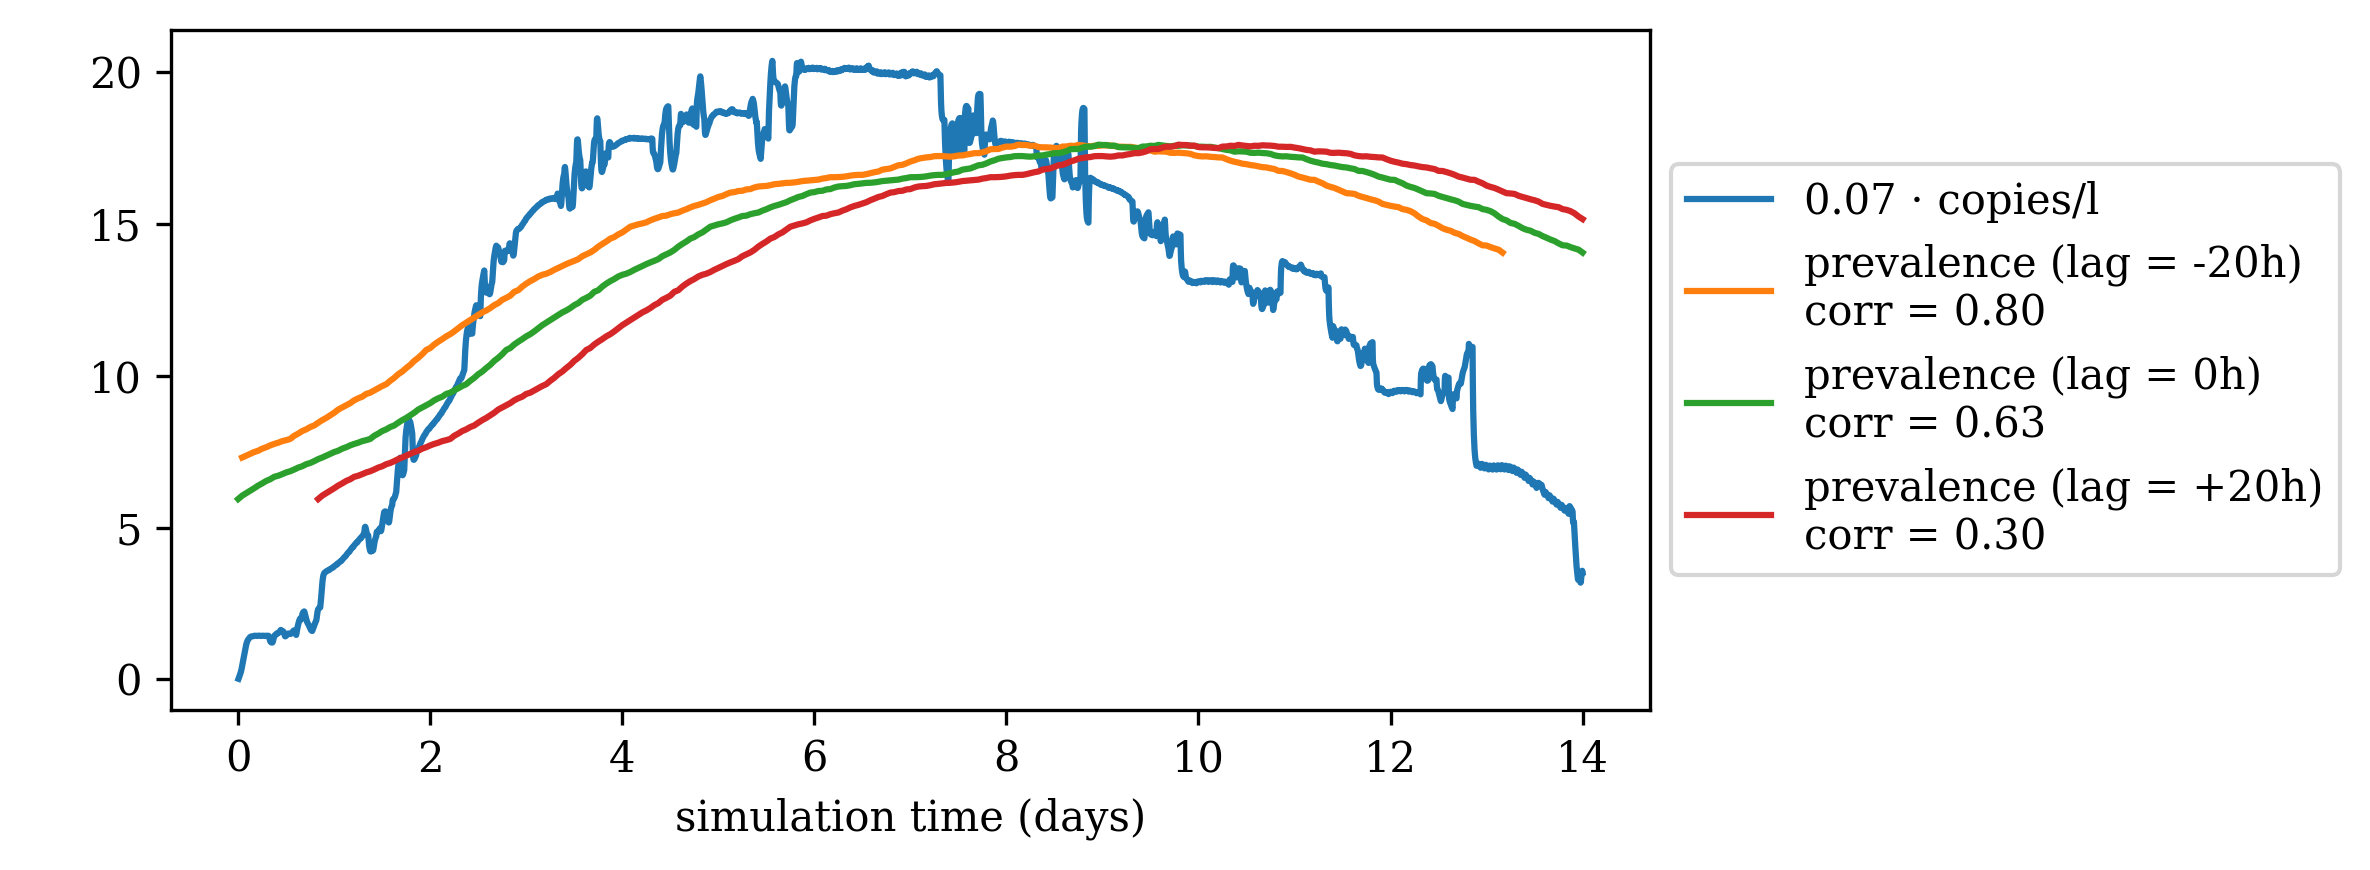

In [52]:
sampling_location = "16"
lag = lag_in_hours
df_sub = df_wastewater_avg.loc[df_wastewater_avg["sampling_point"] == sampling_location,:].copy()
df_sub.sort_values(by="time", inplace=True)
df_prevalence_avg.sort_values(by="time", inplace=True)

fig, ax = plt.subplots(figsize = (8,3), dpi=300) 

sns.lineplot(x=df_sub["time"], y=df_sub["copies/l"]*0.07, label=f"0.07 ⋅ copies/l")

df_psub = df_prevalence_avg.copy()
df_psub["time"] = df_psub["time"]-pd.Timedelta(hours=lag)
df_psub = df_psub.loc[(df_psub["time"] >= df_sub["time"].min()) & (df_psub["time"] <= df_sub["time"].max())]
sns.lineplot(x=df_psub["time"], y=df_psub["I_total"], label=f"prevalence (lag = -{lag}h)\ncorr = {correlations[0]:.2f}")

sns.lineplot(x=df_prevalence_avg["time"], y=df_prevalence_avg["I_total"], label=f"prevalence (lag = 0h)\ncorr = {correlations[1]:.2f}")

df_psub = df_prevalence_avg.copy()
df_psub["time"] = df_psub["time"]+pd.Timedelta(hours=lag)
df_psub = df_psub.loc[(df_psub["time"] >= df_sub["time"].min()) & (df_psub["time"] <= df_sub["time"].max())]
sns.lineplot(x=df_psub["time"], y=df_psub["I_total"], label=f"prevalence (lag = +{lag}h)\ncorr = {correlations[2]:.2f}")

# plt.title("Trajectories of prevalence and wastewater")
plt.xlabel('simulation time (days)')
plt.ylabel(" ")
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
plt.tight_layout()
fig.savefig(os.path.join("systems_output/plots/station_concentration", "correlation", f"trajectories_{sampling_location}.png"), dpi=300)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from matplotlib.dates import DateFormatter

# Define variables
sampling_location = "16"
lag = lag_in_hours

# Find min time
min_time = df_prevalence_avg["time"].min()

df_wastewater_avg["time_since_min"] = (df_wastewater_avg["time"] - min_time).dt.total_seconds() / 86400
df_prevalence_avg["time_since_min"] = (df_prevalence_avg["time"] - min_time).dt.total_seconds() / 86400

# Filter and sort data
df_sub = df_wastewater_avg.loc[df_wastewater_avg["sampling_point"] == sampling_location, :].copy()
df_sub.sort_values(by="time", inplace=True)

# Adjust prevalence data for different lags and plot
df_psub = df_prevalence_avg.copy()
df_psub.sort_values(by="time", inplace=True)



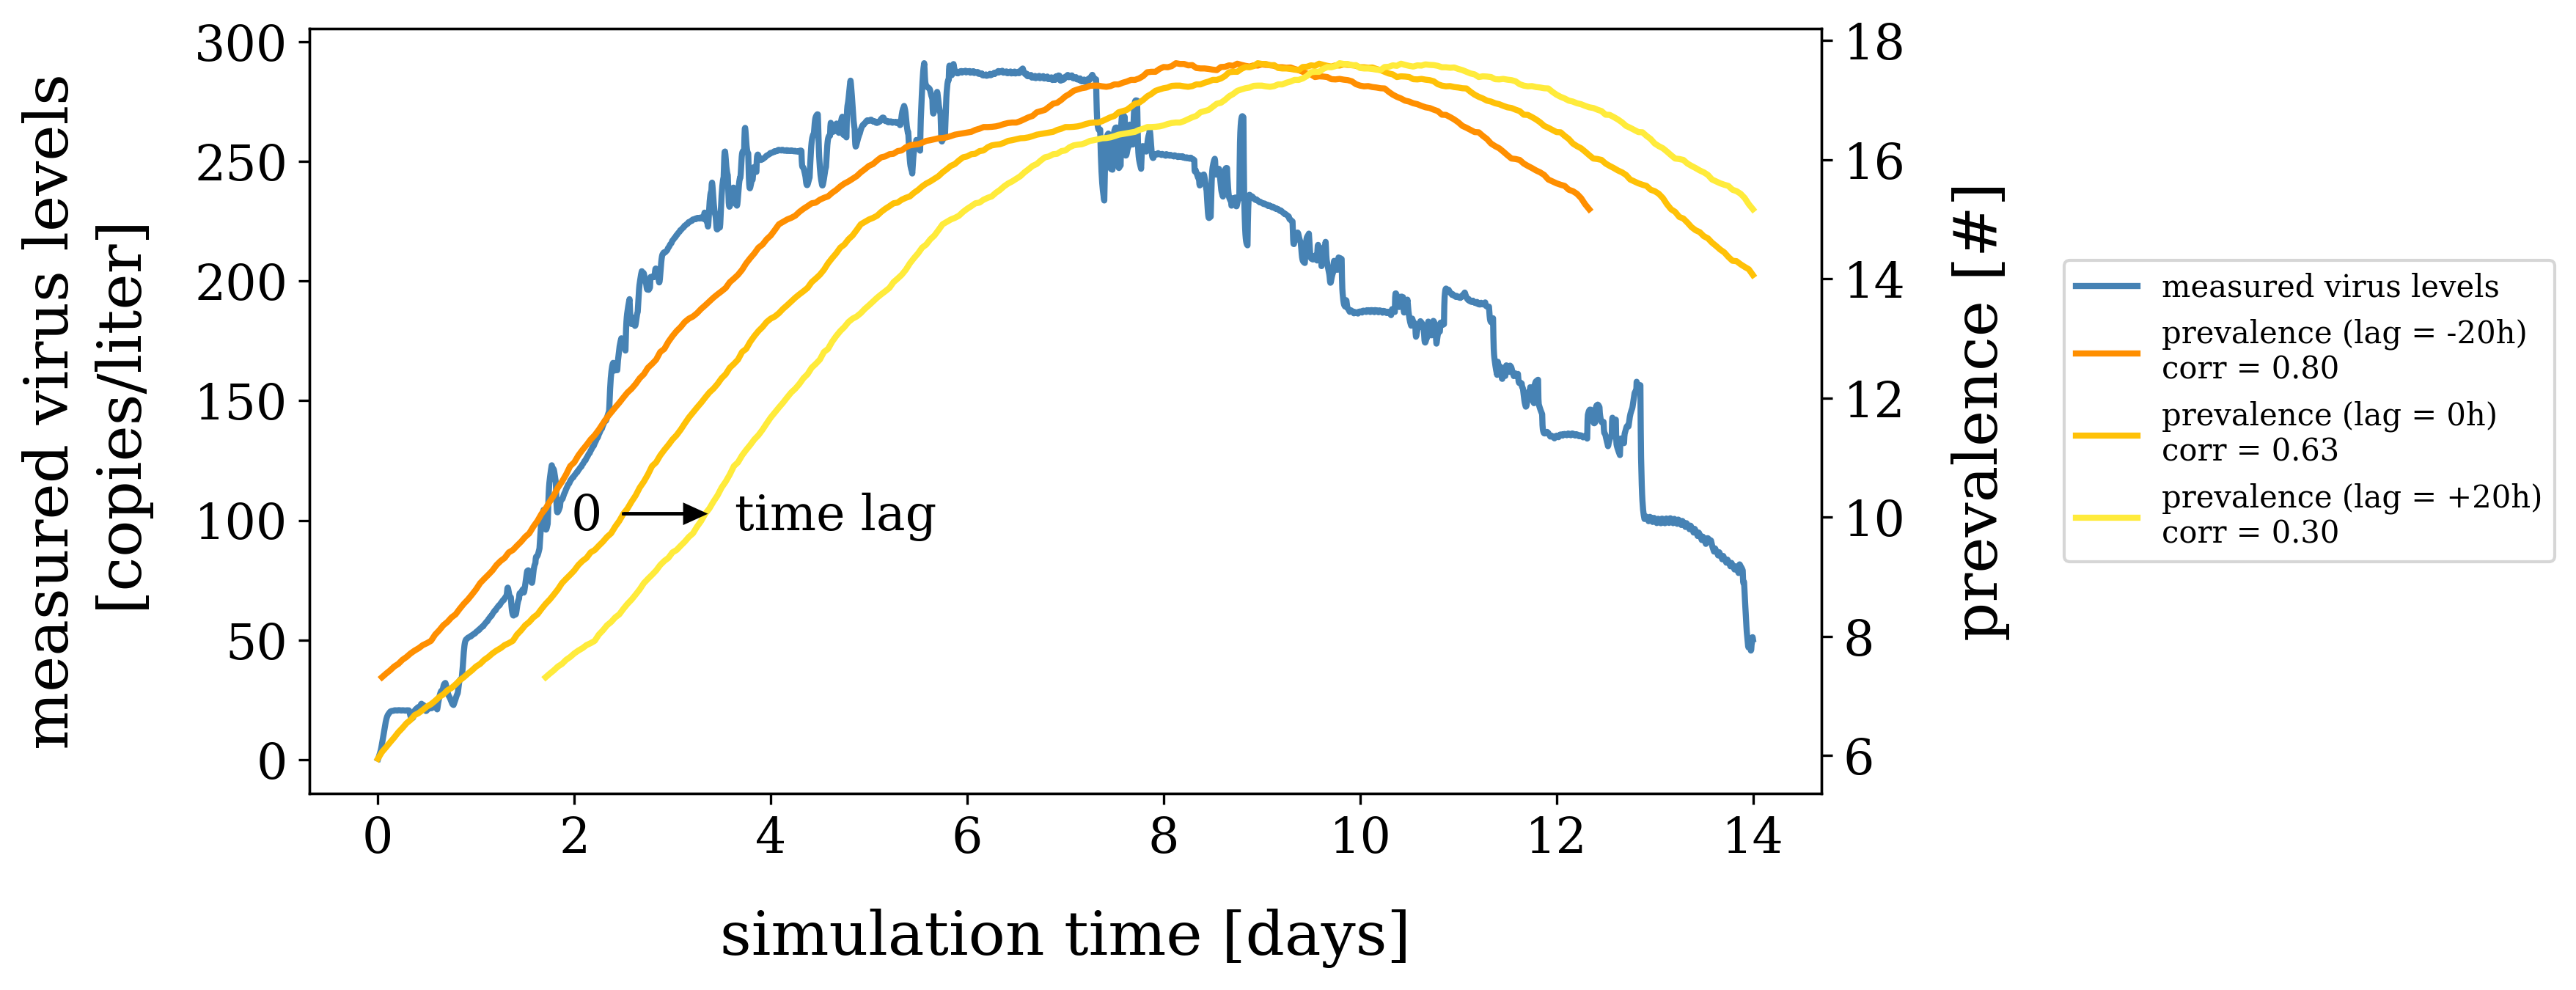

In [219]:
shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (12.2,4.6), dpi=300)

# Plot copies/l on primary y-axis
sns.lineplot(x=df_sub["time_since_min"], y=df_sub["copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2)
ax1.set_ylabel('measured virus levels\n[copies/liter]', labelpad=15,fontsize=20)#, color='steelblue')
ax1.tick_params(axis='y')#, labelcolor='b')

# Create secondary y-axis for prevalence
ax2 = ax1.twinx()

df_psub["time_since_min_minus_lag"] = df_psub["time_since_min"] - lag/24
df_psub = df_psub.loc[(df_psub["time_since_min_minus_lag"] >= df_sub["time_since_min"].min()) & (df_psub["time_since_min_minus_lag"] <= df_sub["time_since_min"].max())]
sns.lineplot(x=df_psub["time_since_min_minus_lag"], y=df_psub["I_total"], label=f"prevalence (lag = -{lag}h)\ncorr = {correlations[0]:.2f}", ax=ax2, color=shades_of_yellow[2], linewidth=2)# 'lightcoral')

sns.lineplot(x=df_prevalence_avg["time_since_min"], y=df_prevalence_avg["I_total"], label=f"prevalence (lag = 0h)\ncorr = {correlations[1]:.2f}", ax=ax2, color=shades_of_yellow[1], linewidth=2)#'indianred')

df_psub["time_since_min_plus_lag"] = df_psub["time_since_min"].apply(lambda x: x + lag / 24)
df_psub = df_psub.loc[(df_psub["time_since_min_plus_lag"] >= df_sub["time_since_min"].min()) & (df_psub["time_since_min_plus_lag"] <= df_sub["time_since_min"].max())]
sns.lineplot(x=df_psub["time_since_min_plus_lag"], y=df_psub["I_total"], label=f"prevalence (lag = +{lag}h)\ncorr = {correlations[2]:.2f}", ax=ax2, color=shades_of_yellow[0], linewidth=2)#'brown')

# Customize secondary y-axis
ax2.set_ylabel('prevalence [#]', labelpad=15,fontsize=20)#, color='indianred')
ax2.tick_params(axis='y')

# ax1.annotate(
#     "lag", 
#     xy=(5, 9.104), 
#     xytext=(3, 100),
#     arrowprops=dict(facecolor='black', shrink=0.05, headwidth=8, width=10)
# )

# Draw arrow
arrow_x = 2.5
arrow_y = df_psub.loc[df_psub["time_since_min"]==arrow_x, "I_total"].iloc[0]
offset = lag/24  # Example offset for the arrow
head_length = 0.2
ax2.arrow(arrow_x, arrow_y, offset-head_length-0.01, 0, head_width=0.3, head_length=head_length, fc='black', ec='black', zorder=5)
#ax2.arrow(arrow_x + (offset), arrow_y, -(offset-head_length-0.01), 0, head_width=0.3, head_length=head_length, fc='black', ec='black', zorder=5)
ax2.annotate("time lag", xy=(arrow_x + offset + head_length + 0.1, arrow_y-0.27), fontsize=16)
ax2.annotate("0", xy=(arrow_x - offset + head_length + 0.1, arrow_y-0.27), fontsize=16)

# Customize x-axis
ax1.set_xlabel('simulation time [days]', labelpad=15,fontsize=20)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Adjust layout and save figure
plt.tight_layout()
# fig.savefig(os.path.join("systems_output/plots/station_concentration", "correlation", f"trajectories_{sampling_location}.png"), dpi=300)

##### Cross correlation based on average values

In [116]:
df_corr = pd.DataFrame()
# 7 days = 168 hours = 2016 5-minute intervals, 12 x 5 minute intervals per h
n_5_minute_lags = range(-1200*2,1200*2+60,60)
df_corr["lag_in_h"] = n_5_minute_lags
df_corr["lag_in_h"] = (df_corr["lag_in_h"]/60*5).astype(int)
df_corr["lag_in_days"] = (df_corr["lag_in_h"]/24)
for sampling_location in df_wastewater_avg["sampling_point"].unique():
    df_corr[sampling_location] = get_crosscorrelation_for_one_station(df_wastewater_avg, df_prevalence_avg, sampling_location, n_5_minute_lags)
df_corr = df_corr.set_index("lag_in_h")

In [128]:
from matplotlib.patches import Rectangle

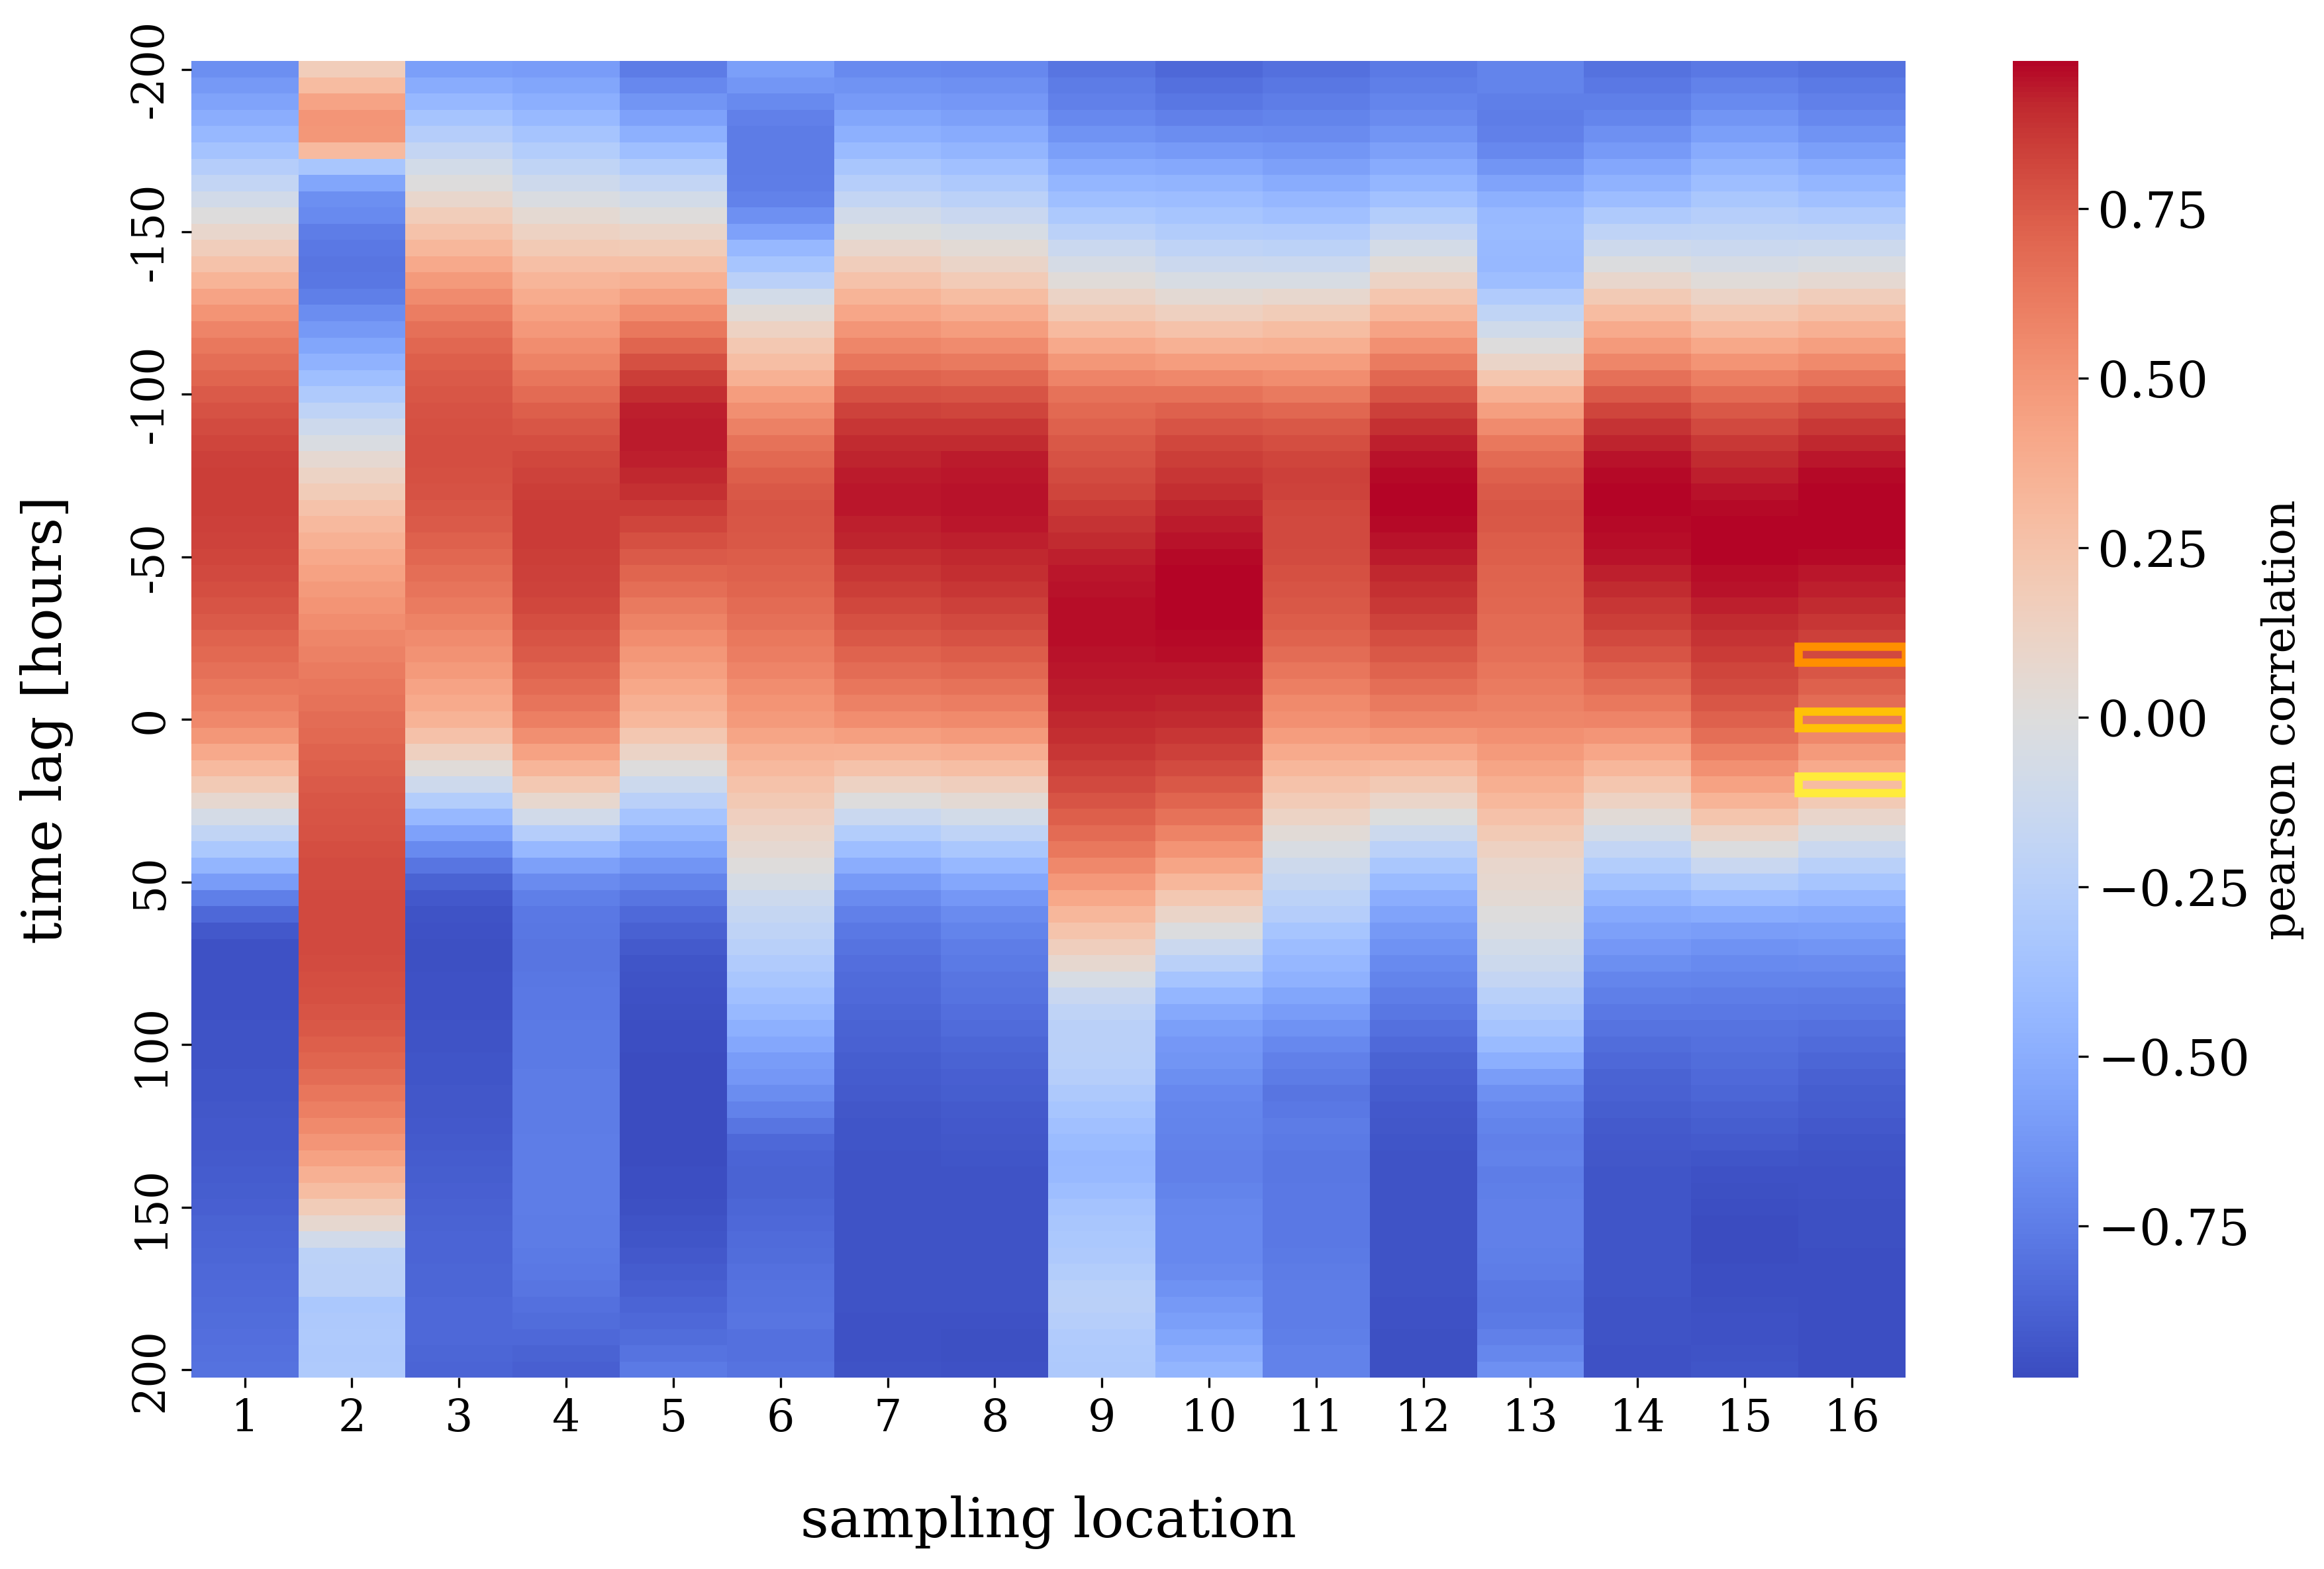

In [220]:
fig, ax = plt.subplots(figsize = (12,8), dpi=300) 
# plt.title("Cross-Correlation between Copies/l and Prevalence")
lb = sns.heatmap(df_corr[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=10, cbar_kws={'label': 'pearson correlation'})
# sns.set(font_scale=1)
#ax.set_title("Cross-Correlation between Copies/l and Prevalence", pad=20)# ,fontsize=20)
ax.set_xlabel("sampling location", labelpad=20,fontsize=20)
ax.set_ylabel("time lag [hours]", labelpad=20,fontsize=20)
lb.figure.axes[-1].yaxis.label.set_size(16)
lb.figure.axes[-1].tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.add_patch(Rectangle((15, df_corr.index.get_loc(-20)), 1, 1, fill=False, edgecolor=shades_of_yellow[2], lw=3))
ax.add_patch(Rectangle((15, df_corr.index.get_loc(0)), 1, 1, fill=False, edgecolor=shades_of_yellow[1], lw=3))
ax.add_patch(Rectangle((15, df_corr.index.get_loc(20)), 1, 1, fill=False, edgecolor=shades_of_yellow[0], lw=3))

plt.tight_layout()
fig.savefig(os.path.join("systems_output/plots/station_concentration","correlation",  "cross_correlation_avg.png"), dpi=300)


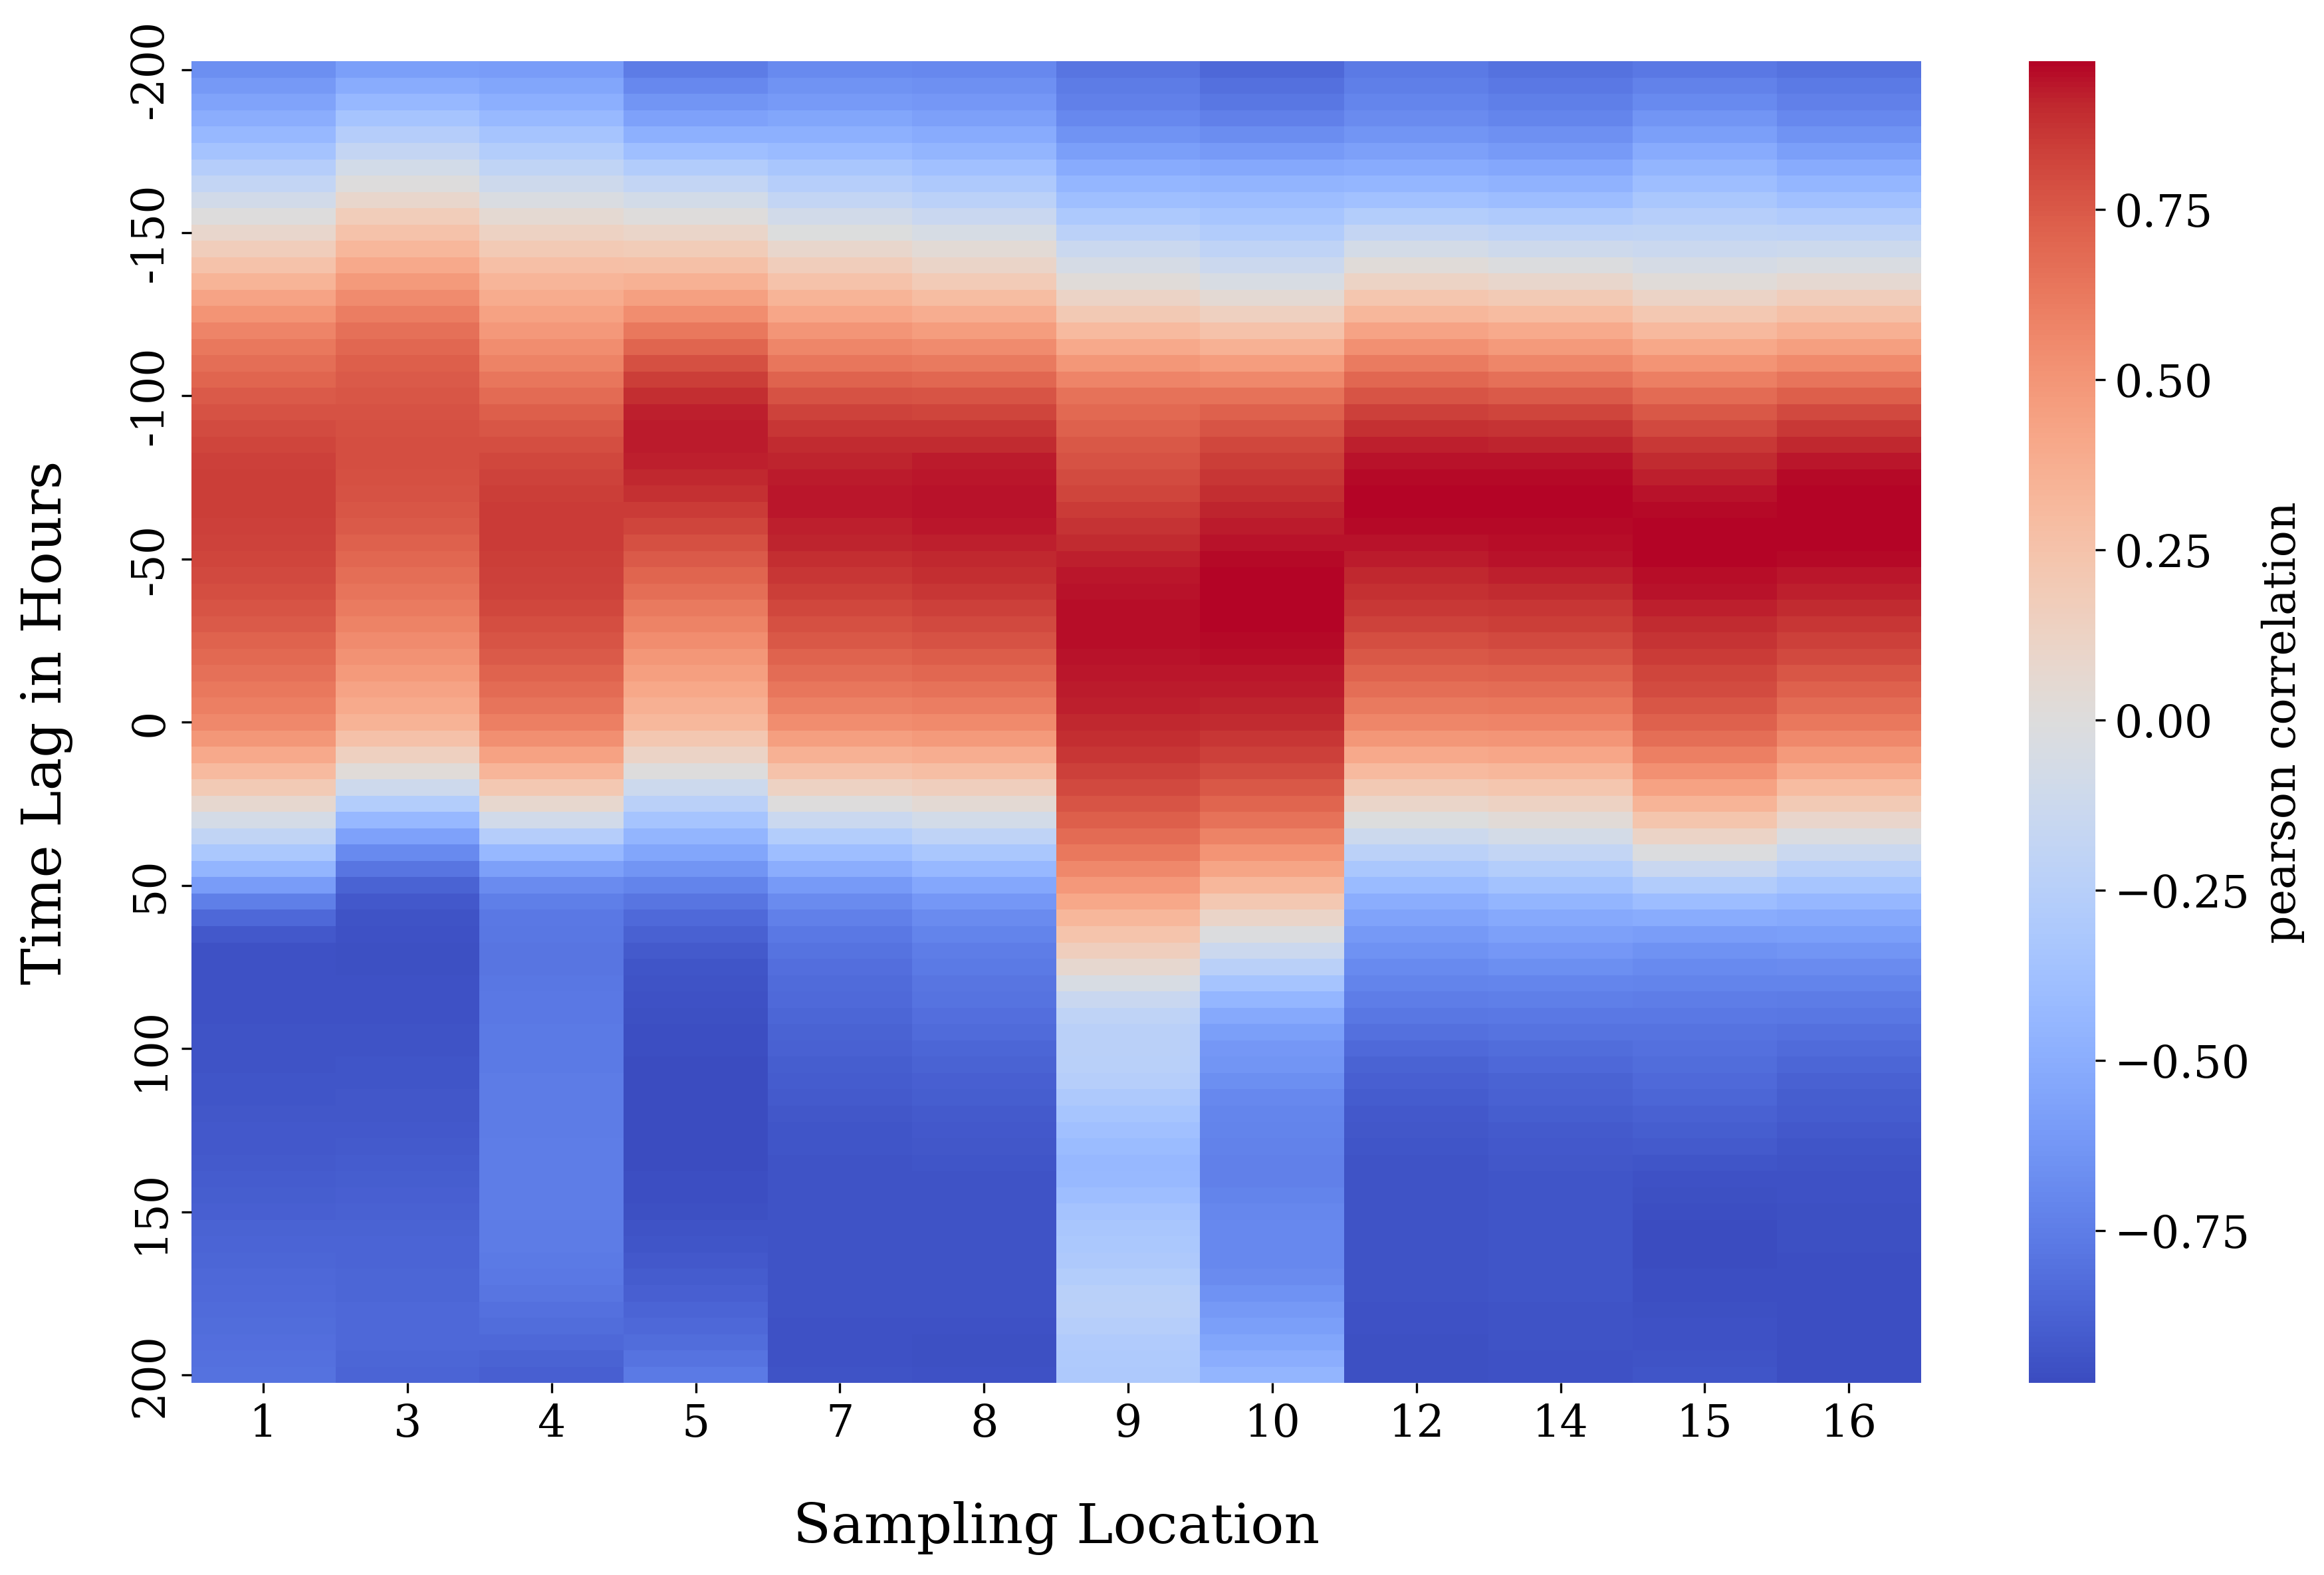

In [ ]:
fig, ax = plt.subplots(figsize = (12,8), dpi=300) 
# plt.title("Cross-Correlation between Copies/l and Prevalence")
lb = sns.heatmap(df_corr[[str(i) for i in range(1,17) if str(i) not in ["2", "6", "11", "13"]]], cmap='coolwarm', center=0, yticklabels=10, cbar_kws={'label': 'pearson correlation'})
# sns.set(font_scale=1)
#ax.set_title("Cross-Correlation between Copies/l and Prevalence", pad=20)# ,fontsize=20)
ax.set_xlabel("Sampling Location", labelpad=20,fontsize=20)
ax.set_ylabel("Time Lag in Hours", labelpad=20,fontsize=20)
lb.figure.axes[-1].yaxis.label.set_size(16)
lb.figure.axes[-1].tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.tight_layout()
fig.savefig(os.path.join("systems_output/plots/station_concentration", "correlation", "cross_correlation_avg_wo_2_6_11_13.png"), dpi=300)


In [ ]:
df_corr.loc[df_corr["16"]==df_corr["16"].max(), "16"]

lag_in_h
-60    0.967436
Name: 16, dtype: float64

### Correlation and Sampling Strategies

In [ ]:
def simulate_sampling_strategies(df):
    df.time = pd.to_datetime(df.time)
    df["day"]= [el.day for el in df.time]
    df["hour"] = [el.hour for el in df.time]

    # consider only valid observations, i.e. with t>0
    df = df.loc[df.minutes >= 0,:]
    # resample every 5 minutes and fill with the last available value
    resampled_df = df.set_index("time").groupby(["sampling_point", "memilio_id"]).resample("5min").ffill()
    # get hourly measurements
    resampled_df = resampled_df.loc[resampled_df.minutes.mod(60) == 0,:]
    # fix column naming and index
    resampled_df.index = [el[2] for el in resampled_df.index]
    resampled_df = resampled_df.reset_index().rename(columns={"index": "time"})
    # calculate 24h samples
    df_24h = resampled_df.groupby(["sampling_point", "memilio_id", "day"]).mean().reset_index().rename(columns={"copies/l": "24h_sample"})
    # only consider 24h samples with 24h of data
    df_24h = df_24h.loc[df_24h.hour==11.5, ["time", "sampling_point", "memilio_id", "24h_sample"]]
    # extract morning sample column
    df_morning_sample = resampled_df.loc[resampled_df.hour==10,:].rename(columns={"copies/l": "morning_sample"}).loc[:,  ["time", "sampling_point", "memilio_id", "morning_sample"]]
    # combine everything
    df_measurements = pd.merge(resampled_df, pd.merge(df_24h, df_morning_sample, on=["sampling_point", "memilio_id", "time"], how="outer"), on=["sampling_point", "memilio_id", "time"], how="outer")
    return df_measurements

In [ ]:
df_sampling = simulate_sampling_strategies(df_wastewater)
df_sampling = pd.melt(df_sampling, id_vars=["time", "sampling_point", "memilio_id"], value_vars=["24h_sample", "morning_sample", "copies/l"]).dropna()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7752eafff760>>
Traceback (most recent call last):
  File "/home/nina/PycharmProjects/INSIDe/inside_demonstrator/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# summarize df_prevalence data
df_prevalence_avg = df_prevalence.groupby(["time"]).mean().reset_index()
df_prevalence_median = df_prevalence.groupby(["time"]).median().reset_index()

# summarize df_wastewater data
df_wastewater_avg = df_sampling.groupby(["time", "sampling_point", "variable"]).mean().reset_index()
df_wastewater_median = df_sampling.groupby(["time", "sampling_point", "variable"]).median().reset_index()

In [ ]:
df_wastewater_avg.columns = ['time', 'sampling_point', 'variable', 'memilio_id', 'copies/l']
# to compare with memilio we need full hour output
df_wastewater_avg.loc[df_wastewater_avg.variable=="24h_sample", "time"] = df_wastewater_avg.loc[df_wastewater_avg.variable=="24h_sample", "time"] + pd.Timedelta(minutes=30)

In [ ]:
df_wastewater_avg.head()

,time,sampling_point,variable,memilio_id,copies/l
0,2024-01-01 01:00:00,1,copies/l,125.500000,9.893200
1,2024-01-01 01:00:00,10,copies/l,125.500000,12.801200
2,2024-01-01 01:00:00,11,copies/l,123.111801,30.914286
3,2024-01-01 01:00:00,12,copies/l,125.500000,8.314400
4,2024-01-01 01:00:00,13,copies/l,124.129464,0.231696


In [ ]:
def get_crosscorrelation_for_one_station(df_wastewater, df_prevalence, sampling_location, n_5_minute_lags):
    df_wastewater_summarized = df_wastewater
    df_prevalence_summarized = df_prevalence

    df_sub_wastewater = df_wastewater_summarized.loc[df_wastewater_summarized["sampling_point"] == sampling_location,:].copy()
    df_sub_wastewater.sort_values(by="time", inplace=True)
    df_prevalence_ = df_prevalence_summarized.sort_values(by="time").copy()

    df_combined = df_sub_wastewater.merge(df_prevalence_, on="time", how="left")[["time", "copies/l", "I_total"]]

    return [crosscorr(df_combined["copies/l"], df_combined["I_total"], lag) for lag in n_5_minute_lags]


In [ ]:
lag_in_hours = 60
max_lag = int(lag_in_hours*60/5)
print(f'precise: {get_crosscorrelation_for_one_station(df_wastewater_avg.loc[df_wastewater_avg.variable=="copies/l"], df_prevalence, "16", [-max_lag, 0.0, max_lag])}')
print(f'morning_sample: {get_crosscorrelation_for_one_station(df_wastewater_avg.loc[df_wastewater_avg.variable=="morning_sample"], df_prevalence, "16", [-max_lag, 0.0, max_lag])}')
print(f'24h_sample: {get_crosscorrelation_for_one_station(df_wastewater_avg.loc[df_wastewater_avg.variable=="24h_sample"], df_prevalence, "16", [-max_lag, 0.0, max_lag])}')

precise: [0.2725627964068618, 0.26605955144704657, 0.2501262646994862]
morning_sample: [0.19877417862940688, 0.2872459818198254, -0.3054125323479381]
24h_sample: [0.13393379007451697, 0.15833051543841256, -0.2990109304236931]


In [ ]:
res = get_crosscorrelation_for_one_station(df_wastewater_avg.loc[df_wastewater_avg.variable=="copies/l"], df_prevalence, "16", range(-1200*2,1200*2+60,60))
np.array(res).max()

0.2828202108298529